# ATMS 523 Module 5 Homework
 - B. Engelsen 10/29/22

#### References
Radar Data consists of measurements from several years in Huntsville, Alabama

Features (radar measurements):
- `Zh` - radar reflectivity factor (dBZ) - use the formula $dBZ = 10\log_{10}(Z)$
- `Zdr` - differential reflectivity
- `Ldr` - linear depolarization ratio
- `Kdp` - specific differential phase
- `Ah` - specific attenuation
- `Adp` - differential attenuation

Target :
- `R` - rain rate

Marshal-Palmer Model:
`Zh` - radar reflectivity factor (dBZ) - use the formula 

$dBZ = 10\log_{10}(Z)$

$Z = 200 R^{1.6}$

# Read in packages

In [85]:
# import seaborn as sb
import xarray as xr
import numpy as np
from glob import glob as gg
import os
import urllib.request # module for downloading data from URLs
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs 
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
import datetime as dt
import chardet
from pandas.tseries.offsets import MonthEnd
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
import h5py
import eofs
from eofs.xarray import Eof
from eofs.examples import example_data_path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import sklearn.metrics as metrics
import wradlib as wrl

# Read in radar data using pandas

In [3]:
Radar_data = pd.read_csv('/Users/Bryan.Engelsen/Documents/GitHub/ATMS523/machine-learning-1-bengelsen23/homework/radar_parameters.csv')

In [4]:
Radar_data.head()

,Unnamed: 0,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


In [5]:
Radar_data = Radar_data.drop('Unnamed: 0', axis=1)

# EDA

In [6]:
# %matplotlib inline
# import seaborn as sns; sns.set()
# sns.pairplot(Radar_data, hue='R (mm/hr)', height=1.5)

# Baseline Prediction

In [97]:
#Solve for R 
R_base_old = ((10**(Radar_data['Zh (dBZ)']/10))/200)**1/1.6
Z = wrl.trafo.idecibel(Radar_data['Zh (dBZ)'])
R_base = wrl.zr.z_to_r(Z, a=200.0, b=1.6)

# Split data

In [8]:
X_radar = Radar_data.drop('R (mm/hr)', axis=1)
# X_iris.shape
y_radar = Radar_data['R (mm/hr)']
# y_iris.shape

# X = features, predictors
# y = label, predictand, target

In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_radar, y_radar,
                                                test_size=0.30, random_state=12)

# X = features, predictors
# y = label, predictand, target

# Import model from Scikit Learn

In [10]:
from sklearn.linear_model import LinearRegression   # 1. choose model class
model = LinearRegression(fit_intercept=True)        # 2. instantiate model
model.fit(Xtrain, ytrain)                           # 3. fit model to data
ymodel = model.predict(Xtest)                       # 4. predict on new data

# X = features, predictors
# y = label, predictand, target

In [66]:
# model.coef_
# model.intercept_

Mean Absolute Error: 0.55 degrees.
Testing Accuracy: 86.93 %.


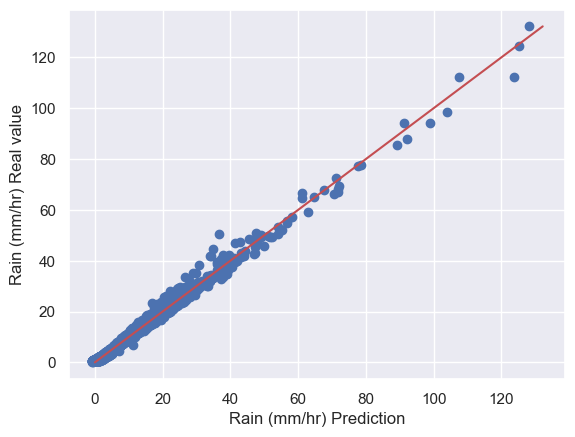

In [14]:
# Adapted from https://www.kaggle.com/code/arjunshakdher/data-mining-ml-using-air-quality-data/notebook

errors = abs(ymodel - ytest)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / ytest)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Testing Accuracy:', round(accuracy, 2), '%.')
 
# Build a plot
plt.scatter(ymodel, ytest)
plt.xlabel('Rain (mm/hr) Prediction')
plt.ylabel('Rain (mm/hr) Real value')

# Now add the perfect prediction line
diagonal = np.linspace(0, np.max(ytest), 100)
plt.plot(diagonal, diagonal, '-r')
plt.show()

# Model Statistics Relative to Testing Dataset

In [15]:
print("Results of sklearn.metrics for comparison to Regression Model:")
print('R^2 = ',model.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel,squared=False))

Results of sklearn.metrics for comparison to Regression Model:
R^2 =  0.9894849499729809
RMSE =  0.8607804980876644


Model Statistics Relative to Marshal-Palmer Baseline Empirical Model

In [99]:
# calculate manually
# d = y_radar - R_base
# mse_f = np.mean(d**2)
# mae_f = np.mean(abs(d))
# rmse_f = np.sqrt(mse_f)
# r2_f = 1-(sum(d**2)/sum((y_radar-np.mean(y_radar))**2))

mae = metrics.mean_absolute_error(y_radar, R_base)
mse = metrics.mean_squared_error(y_radar, R_base)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_radar,R_base)

print("Results of sklearn.metrics for comparison to Marshall-Palmer:")
# print("MAE:",mae)
# print("MSE:", mse)
print("R-Squared:", r2)
print("RMSE:", rmse)


Results of sklearn.metrics for comparison to Marshall-Palmer:
R-Squared: 0.3023229070437503
RMSE: 7.157590840042378


# Repeat doing a grid search over polynomial orders, using a grid search over orders 0-21, and use cross-validation of 7 folds.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=7, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

# model_poly = make_pipeline(PolynomialFeatures(degree=7),LinearRegression())
# ytest = model_poly.fit(Xtrain,ytrain).predict(Xtest)

Text(0, 0.5, 'score')

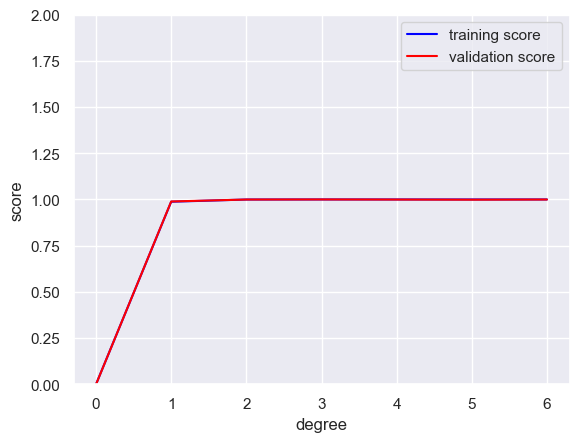

In [18]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 7)
train_score, val_score = validation_curve(PolynomialRegression(degree), Xtrain, ytrain,
                                          param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 2)
plt.xlabel('degree')
plt.ylabel('score')

In [19]:
model2 = PolynomialRegression(1)
ymodel2 = model2.fit(Xtrain, ytrain).predict(Xtest)

In [100]:
print("Results of sklearn.metrics for comparison to Regression Model:")
print('R^2 = ',model.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel,squared=False))

print("Results of sklearn.metrics for comparison to Marshall-Palmer:")
# print("MAE:",mae)
# print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

print("Results of sklearn.metrics for comparison to Polynomial Regression Model:")
print('R^2 = ', model2.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel2,squared=False))

Results of sklearn.metrics for comparison to Regression Model:
R^2 =  0.9894849499729809
RMSE =  0.8607804980876644
Results of sklearn.metrics for comparison to Marshall-Palmer:
RMSE: 7.157590840042378
R-Squared: 0.3023229070437503
Results of sklearn.metrics for comparison to Polynomial Regression Model:
R^2 =  0.9894849499729806
RMSE =  0.8607804980876731


# Using Random Forrect Regressor to predict Rain rate with Parameter Grid Search

In [21]:
#adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],  
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
'max_features': ['auto', 'sqrt'],  
'min_samples_leaf': [1, 2, 4],  
'min_samples_split': [2, 5, 10],  
'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

model_rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=12, n_jobs = -1)
# Fit the random search model
model3 = rf_random.fit(Xtrain, ytrain)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [22]:
ymodel3 = model3.predict(Xtest)

In [101]:
print("Results of sklearn.metrics for comparison to Regression Model:")
print('R^2 = ',model.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel,squared=False))

print("Results of sklearn.metrics for comparison to Marshall-Palmer:")
# print("MAE:",mae)
# print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

print("Results of sklearn.metrics for comparison to Polynomial Regression Model:")
print('R^2 = ', model2.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel2,squared=False))

print("Results of sklearn.metrics for comparison to Random Forrest Regression Model:")
print('R^2 = ',model3.score(Xtest, ytest))
print('RMSE = ',mean_squared_error(ytest, ymodel3, squared=False))

Results of sklearn.metrics for comparison to Regression Model:
R^2 =  0.9894849499729809
RMSE =  0.8607804980876644
Results of sklearn.metrics for comparison to Marshall-Palmer:
RMSE: 7.157590840042378
R-Squared: 0.3023229070437503
Results of sklearn.metrics for comparison to Polynomial Regression Model:
R^2 =  0.9894849499729806
RMSE =  0.8607804980876731
Results of sklearn.metrics for comparison to Random Forrest Regression Model:
R^2 =  0.9804771241608146
RMSE =  1.1728936729534252


In [ ]:
# print(random_grid)